In [31]:
from __future__ import print_function
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision import models, transforms
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
from functools import partial

from few_shot_learning.datasets import FashionProductImages, FashionProductImagesSmall
from few_shot_learning.utils_evaluation import ToSize
from few_shot_learning.train_transfer import transfer
from few_shot_learning.utils_evaluation import evaluate_transfer
from few_shot_learning.utils import accuracy
from config import DATA_PATH

# 1. Data Preprocessing and Statistics

Preprocessing and loading of image samples and label information is accomplished through the classes `few_shot_learning.dataset.FashionProductImages` and `few_shot_learning.datasets.FashionProductImagesSmall`. Important arguments are `split` and `classes`. For the purposes of transfer learning, the split should be one of `split='train'` or `split='test'` and the classes one of `classes='top'` or `classes='bottom'` selecting the top 20 classs with the most samples or the remaining 123 classes.

The following code snippets illustrate the functionality:

In [2]:
all_data = FashionProductImagesSmall(DATA_PATH, split='all', classes=None)

The complete dataset description looks like this:

In [3]:
all_data.df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,productDisplayName2,filename,my_id,class_id
0,0,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,NaN,15970.jpg,15970,104
1,1,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,NaN,39386.jpg,39386,56
2,2,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,NaN,59263.jpg,59263,140
3,3,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,NaN,21379.jpg,21379,128
4,4,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,NaN,53759.jpg,53759,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44441,44436,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,NaN,17036.jpg,17036,19
44442,44437,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,NaN,6461.jpg,6461,39
44443,44438,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,NaN,18842.jpg,18842,134
44444,44439,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,NaN,46694.jpg,46694,91


In [4]:
datasets = dict()

for classes in ['top', 'bottom', None]:
    
    datasets[classes] = dict()
    
    for split in ['train', 'test', 'all']:
        
        dataset = FashionProductImages(DATA_PATH, split=split, classes=classes, transform=ToSize())
        size = len(dataset)
        loader = DataLoader(dataset, batch_size=size, shuffle=False, num_workers=8)
        
        # use loader to efficiently load all images using multiple workers
        #for widths_heights, labels in loader:
        #    break
        
        #widths, heights = widths_heights
        #widths = widths.numpy()
        #heights = heights.numpy()
        #labels = labels.numpy()
        
        datasets[classes][split] = dict(data=dataset,
                                        size=size,
                                        loader=loader)#,
                                        #widths=widths,
                                        #heights=heights,
                                        #labels=labels)


## 1.1. Distribution of image sizes and aspect ratios

We first have a look at the image format and sizes. It turns out they're half-way regular, mostly 1800-by-1200 pixels or 2400-by-1800 pixels, mostly RGB. Aspect ratio is almost always $4/3$. The resolution is quite high, I chose to convert all images of the full dataset to **400-by-300 pixels** (not shown here).

In [5]:
from matplotlib.colors import LogNorm

unique_heights = np.unique(datasets['top']['train']['heights'])
unique_widths = np.unique(datasets['top']['train']['widths'])
print(unique_heights)
print(unique_widths)

plt.figure(figsize=(12,9))
plt.hist2d(
    datasets['top']['train']['heights'],
    datasets['top']['train']['widths'],
    bins=[unique_heights, unique_widths],
    norm=LogNorm(),
)
plt.xticks(unique_heights)
plt.yticks(unique_widths)
plt.colorbar()
plt.show()

KeyError: 'heights'

In [ ]:
aspect_ratios = datasets['top']['train']['heights']/datasets['top']['train']['widths']
unique_aspect_ratios = np.unique(aspect_ratios)
print(unique_aspect_ratios)
print((aspect_ratios == 4/3).sum())

plt.figure(figsize=(8,6))
plt.hist(aspect_ratios)
plt.show()

## 1.2. Distribution of Classes in Training and Test Set

Importantly, the distribution of classes in the training and test set is quite different. For the chosen master split, all training samples are from **even** years and all test samples are from **odd** years.

The histogram below illustrates the differences between training and test set. The most striking difference is the class `'Perfume and Body Mist'` which is **absent from the training set**. Additionally, although this is less concerning, some classes are almost absent from the test set (classes `'Watches'` and `'Sunglasses'`)

The situation is worse for the remaining 123 classes. There we observe a substantial mismatch between the class distributions of training and test set, as shown below.

In [5]:
def get_mapped_class_dist(dataset, classes, normed=False):
    class_dist = np.bincount(dataset.target_indices, minlength=len(classes))
    
    if normed:
        class_dist = class_dist / class_dist.sum()
        
    class_indices = dataset.target_codec.transform(classes)
    
    return class_dist[class_indices]
    

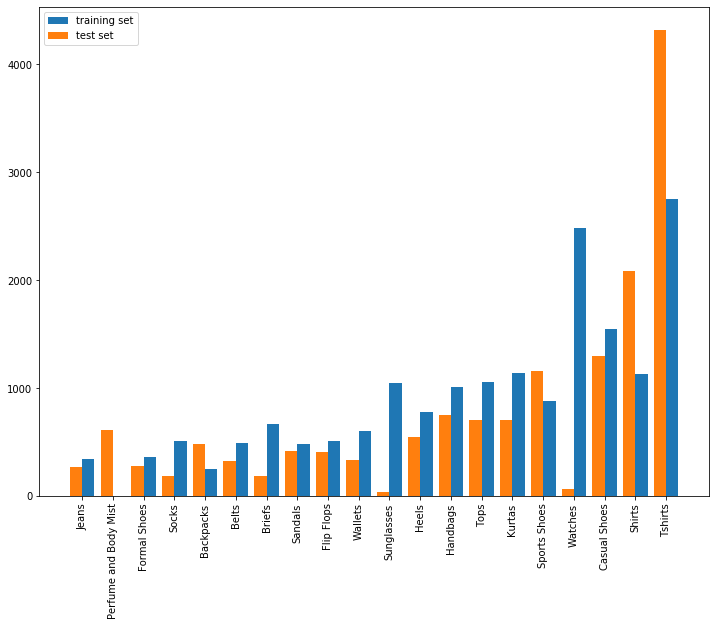

In [6]:
# top 20 classes
top20 = FashionProductImages.top20_classes

plt.figure(figsize=(12,9))
plt.bar(top20, get_mapped_class_dist(datasets['top']['train']['data'], top20), label='training set', width=0.4, align='edge')
plt.bar(top20, get_mapped_class_dist(datasets['top']['test']['data'], top20), label='test set', width=-0.4, align='edge')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

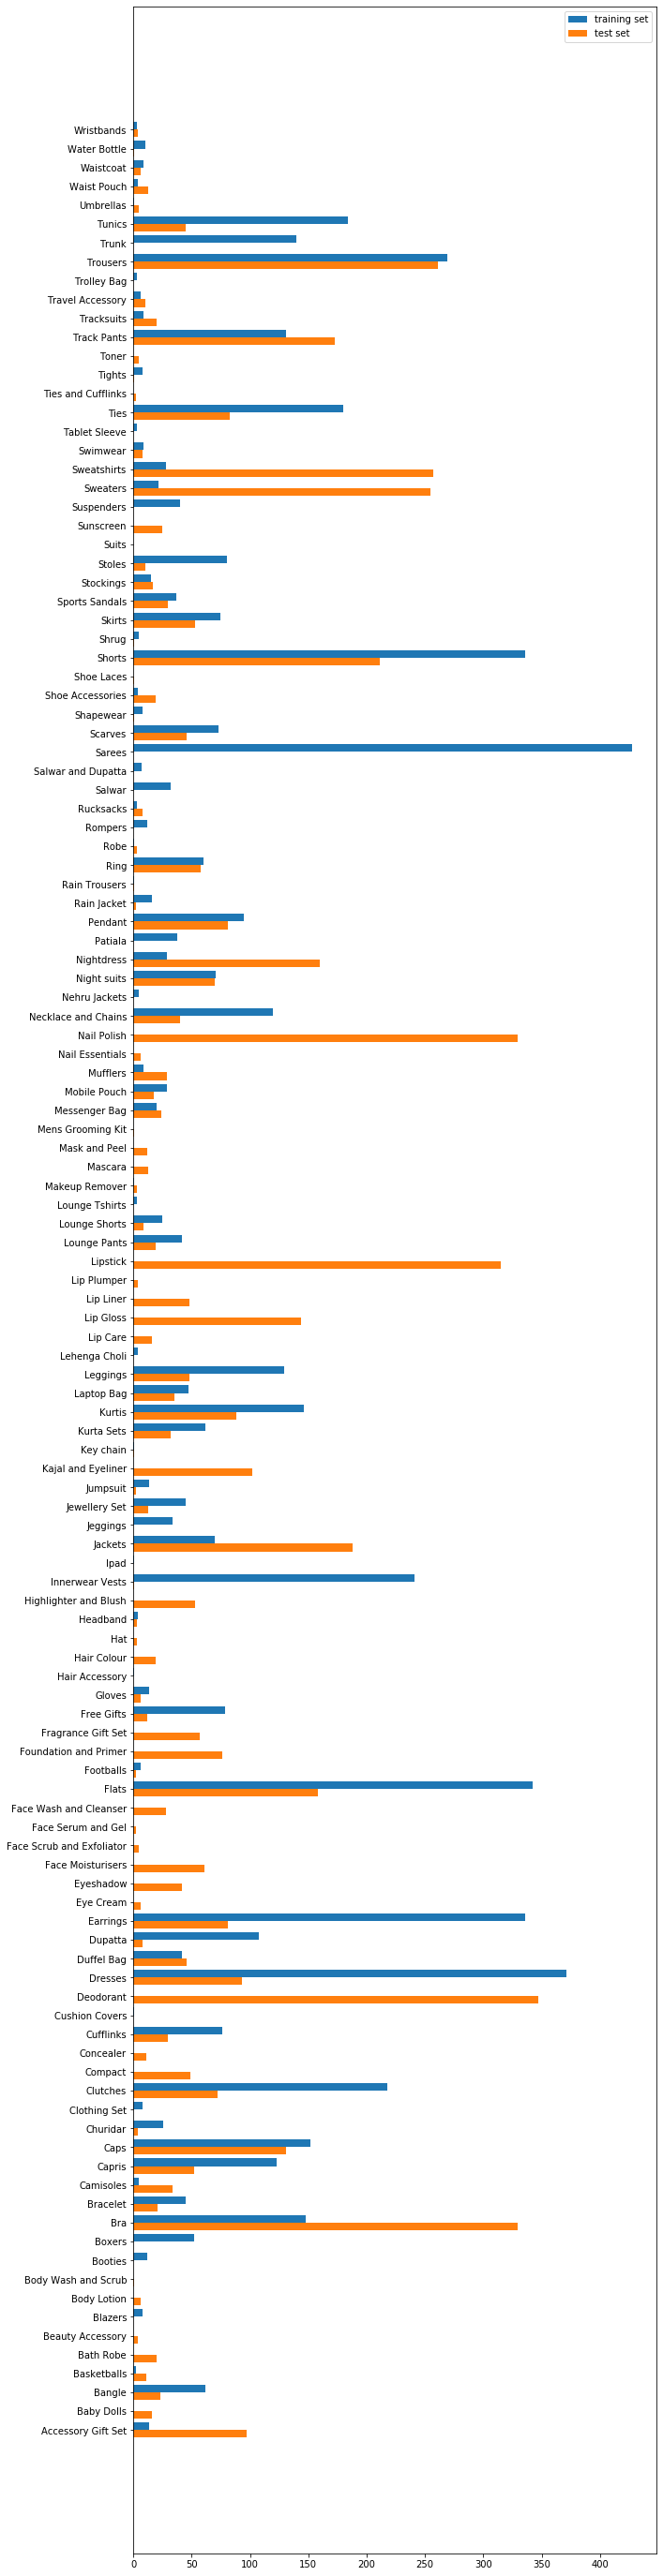

In [7]:
bottom123 = datasets['bottom']['train']['data'].classes

bottom_train_dist = get_mapped_class_dist(datasets['bottom']['train']['data'], bottom123)
bottom_test_dist =get_mapped_class_dist(datasets['bottom']['test']['data'], bottom123)

plt.figure(figsize=(10,50))
plt.barh(bottom123, bottom_train_dist, label='training set', height=0.4, align='edge')
plt.barh(bottom123, bottom_test_dist, label='test set', height=-0.4, align='edge')
# plt.xticks(rotation='vertical')
plt.legend()
plt.show()

Classes **not present in the training set** while present in the test set and their relative proportion in the test set:

In [8]:
testonly_classes = bottom123[(bottom_test_dist > 0) & (bottom_train_dist == 0)]

print(testonly_classes)

['Baby Dolls' 'Bath Robe' 'Beauty Accessory' 'Body Lotion'
 'Body Wash and Scrub' 'Compact' 'Concealer' 'Deodorant' 'Eye Cream'
 'Eyeshadow' 'Face Moisturisers' 'Face Scrub and Exfoliator'
 'Face Serum and Gel' 'Face Wash and Cleanser' 'Foundation and Primer'
 'Fragrance Gift Set' 'Hair Colour' 'Hat' 'Highlighter and Blush'
 'Kajal and Eyeliner' 'Lip Care' 'Lip Gloss' 'Lip Liner' 'Lip Plumper'
 'Lipstick' 'Mascara' 'Mask and Peel' 'Mens Grooming Kit'
 'Nail Essentials' 'Nail Polish' 'Shoe Laces' 'Sunscreen'
 'Ties and Cufflinks' 'Toner']


In [9]:
# proportion of test samples affected
print(bottom_test_dist[(bottom_test_dist > 0) & (bottom_train_dist == 0)].sum() / bottom_test_dist.sum())

0.33224341507720256


Furthermore, there are classes present in the training set which are **absent from the test set**.

In [10]:
# classes not present in the test set while present in the training set
trainonly_classes = bottom123[(bottom_test_dist == 0) & (bottom_train_dist > 0)]

print(trainonly_classes)

['Blazers' 'Booties' 'Boxers' 'Clothing Set' 'Cushion Covers'
 'Hair Accessory' 'Ipad' 'Jeggings' 'Lehenga Choli' 'Lounge Tshirts'
 'Nehru Jackets' 'Patiala' 'Rompers' 'Salwar' 'Salwar and Dupatta'
 'Sarees' 'Suspenders' 'Tablet Sleeve' 'Trolley Bag' 'Trunk']


Finally, there are classes which are missing from both training and test set. These are classes that nominally have samples in `styles.csv` but whose images are missing from folder `images/`. They won't affect neither training nor testing in any way.

In [11]:
# classes neither in the training set nor test set
missing_classes = bottom123[(bottom_test_dist == 0) & (bottom_train_dist == 0)]

print(missing_classes)

['Suits']


# 2. Tests

Run `pytest` in the root directory to run tests.

# 3. Training

A training run can also be started via e.g.

```
python -m experiments.transfer_learning -a resnet50 -p 50 --distributed --date --epochs 100
```

For a list of arguments, refer to the help message:

In [12]:
run "~/few-shot-learning/experiments/transfer_experiment.py" -h

usage: transfer_experiment.py [-h] [--data DIR] [-a ARCHITECTURE] [-j N]
                              [--epochs N] [-b N] [--lr LR] [--lr_tr LR]
                              [--optim OPTIMIZER] [--optim-args DICT] [-p N]
                              [--seed SEED] [--gpu GPU] [--distributed]
                              [--date] [--small-dataset]

PyTorch Transfer Learning

optional arguments:
  -h, --help            show this help message and exit
  --data DIR            path to dataset
  -a ARCHITECTURE, --arch ARCHITECTURE
                        model architecture: alexnet | densenet121 |
                        densenet161 | densenet169 | densenet201 | googlenet |
                        inception_v3 | mobilenet_v2 | resnet101 | resnet152 |
                        resnet18 | resnet34 | resnet50 | resnext101_32x8d |
                        resnext50_32x4d | shufflenet_v2_x0_5 |
                        shufflenet_v2_x1_0 | shufflenet_v2_x1_5 |
                        shufflenet_v

I focused on running experiments with ResNet50. These are the important decisions for the training procedure:

- *n_epochs*: 100
- *learning rate schedule*:
    - Top20 initial finetuning: `learning_rate=1e-3`, decayed by 0.7 every 5 epochs (ad-hoc choice)
    - Transfer learning: `learning_rate=1e-3`, decayed by 0.7 every 5 epochs (ad-hoc choice)
- *optimizer*: `torch.optim.Adam`
- *batch_size*: 64
- *model architecture*: **ResNet50** (trained on 2 GPUs with `torch.nn.DataParallel`)
- *validation*:
    - Top20 initial finetuning: selected the model with the best validation accuracy on a random 10% of training samples. Training and validation sets stratified across classes. Continued with this model for transfer learning.
    - Transfer learning: selected the model with the best validation accuracy on a random 10% of training samples again.
    Training and validation sets not stratified.
- *data augmentation*: `torchvision.transforms.RandomResizedCrop`, `torchvision.transforms.ColorJitter`, `torchvision.transforms.RandomHorizontalFlip`.
- *balanced training*: When sampling from the training set, I sampled uniformly from all classes (both finetuning and transfer). This means I undersampled classes with many samples and oversampled classes with very few samples. I could have alternatively implemented a weighted loss function or a focal loss to give higher weight to classes with fewer samples. Importantly, there is no a priori reason to believe that certain misclassifications are worse than others for our dataset (e.g. something like misclassifying suits is worse than misclassifying jeans.). For this reason, balanced training was employed only to combat overfitting on dominant classes and to thus improve overall test performance. Consequently, no balanced sampling was employed for the validation set (to be closer to the test set).

Training can also be run with:

In [ ]:
transfer(
    data_dir=DATA_PATH,
    architecture='resnet50',
    num_workers=8,
    epochs=100,
    batch_size=64,
    learning_rate=1e-3,
    optimizer_cls=torch.optim.Adam,
    print_freq=50,
    seed=None,
    distributed=True,
    date_prefix=True,
    model_dir=os.path.expanduser("~/few-shot-learning/models"),
    log_dir=os.path.expanduser("~/few-shot-learning/logs")
)

# 4. Evaluation

In [14]:
LOG_DIR = os.path.expanduser("~/few-shot-learning/logs/")
MODEL_DIR = os.path.expanduser("~/few-shot-learning/models/")

folder = "19_10_08_1917"

In [15]:
finetuning_results = torch.load(os.path.join(LOG_DIR, folder, "finetuning_training_log.json"))
transfer_results = torch.load(os.path.join(LOG_DIR, folder, "transfer_training_log.json"))

In [16]:
finetuning_best_model = torch.load(
    os.path.join(MODEL_DIR, folder, "finetuning_model_best_unwrapped.pth.tar"),
    map_location=torch.device('cuda', 1)
)
transfer_best_model = torch.load(
    os.path.join(MODEL_DIR, folder, "transfer_model_best_unwrapped.pth.tar"),
    map_location=torch.device('cuda', 1)
)

## 4.1 Monitoring Training

The learning curves below show training and validation losses and accuracies over the course of training. In general, training seems to have been successful with the ad-hoc choice of initial learning rates and learning rate schedules.

The initial finetuning learning curve for the validation loss hints at overfitting but the validation accuracy is best later in training. The best model is marked by a horizontal line. Top5 validation accuracy rises to almost 100% for the best model.

The transfer learning seems to have been successful as well. The best top1 validation accuracy is lower than for the initial finetuning on the top-20 classes.

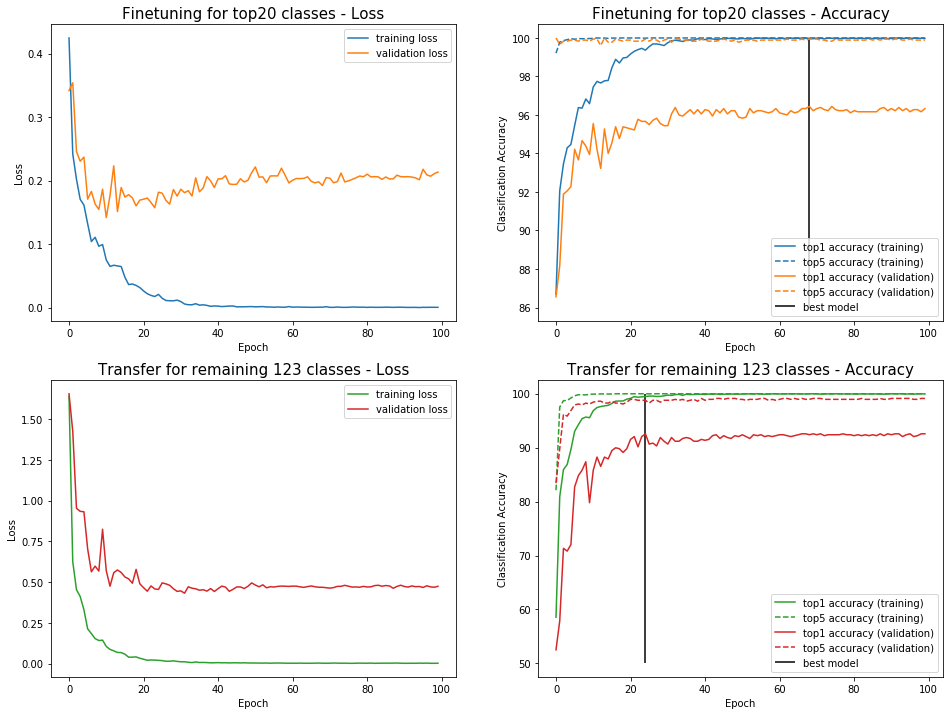

In [17]:
plt.figure(figsize=(16,12))

plt.subplot(221)
plt.plot(finetuning_results["train_loss"], label="training loss")
plt.plot(finetuning_results["val_loss"], label="validation loss")
plt.title("Finetuning for top20 classes - Loss", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(222)
plt.plot(finetuning_results["train_acc1"], label="top1 accuracy (training)", color='#1f77b4')
plt.plot(finetuning_results["train_acc5"], label="top5 accuracy (training)", color='#1f77b4', linestyle="--")
plt.plot(finetuning_results["val_acc1"], label="top1 accuracy (validation)", color='#ff7f0e')
plt.plot(finetuning_results["val_acc5"], label="top5 accuracy (validation)", color='#ff7f0e', linestyle="--")
plt.vlines(finetuning_best_model["epoch"]-1, 86, 100, label="best model")
plt.title("Finetuning for top20 classes - Accuracy", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy")
plt.legend()

plt.subplot(223)
plt.plot(transfer_results["train_loss"], label="training loss", color='#2ca02c')
plt.plot(transfer_results["val_loss"], label="validation loss", color='#d62728')
plt.title("Transfer for remaining 123 classes - Loss", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(224)
plt.plot(transfer_results["train_acc1"], label="top1 accuracy (training)", color='#2ca02c')
plt.plot(transfer_results["train_acc5"], label="top5 accuracy (training)", color='#2ca02c', linestyle="--")
plt.plot(transfer_results["val_acc1"], label="top1 accuracy (validation)", color='#d62728')
plt.plot(transfer_results["val_acc5"], label="top5 accuracy (validation)", color='#d62728', linestyle="--")
plt.vlines(transfer_best_model["epoch"]-1, 50, 100, label="best model")
plt.title("Transfer for remaining 123 classes - Accuracy", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy")
plt.legend()

plt.show()

## 4.2. Performance on Test Set

For the initial finetuning on the top-20 classes the test set performance is given below. Importantly, test performance is substantially impacted by the class that was missing from the training set:

| Finetuning (Top-20) - Test Set Accuracy |       Top1    | Top5 |
|-------------------------------------------------------|------|-----|
| average across classes                                | 88.3 | 95.4|
| average across classes (w/o 'Perfume and Body Mist')  | 92.1 | 99.4|

For transfer learning on the remaining classes the test set performance is. Here the problem of test-only classes is even more pronounced.

| Transfer (Remaining classes) Test Set Accuracy |       Top1    | Top5 |
|-------------------------------------------------------|------|-----|
| average across classes                                | 46.8 | 60.5|
| average across classes (w/o test-only classes)        | ?    | ?   |


Detailed results for classwise accuracies are shown in the histograms below.

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda', 1)
else:
    device = torch.device('cpu')

In [19]:
acc1_avg, acc5_avg, acc1_classwise, acc5_classwise, outputs, targets = evaluate_transfer(
    finetuning_best_model['state_dict'],
    device=device,
    architecture='resnet50',
    classes='top',
    small_dataset=False,
    num_workers=4,
    batch_size=128
)

In [20]:
print(acc1_avg, acc5_avg)

88.32266235351562 95.35282897949219


In [32]:
perfume_class = datasets['top']['test']['data'].target_codec.transform(["Perfume and Body Mist"])

acc1_without_perfume, acc5_without_perfume = accuracy(
    outputs[targets != perfume_class[0]], targets[targets != perfume_class[0]], topk=(1, 5))

In [34]:
print(acc1_without_perfume.item(), acc5_without_perfume.item())

92.05366516113281 99.38080596923828


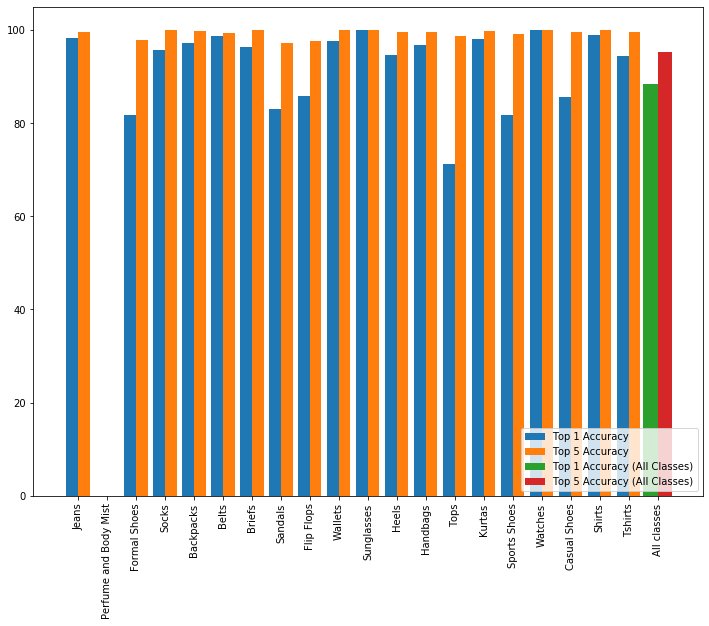

In [44]:
plt.figure(figsize=(12,9))
plt.bar(top20 + ["All classes"], list(acc1_classwise[datasets['top']['test']['data'].target_codec.transform(top20)]) + [0.0], label='Top 1 Accuracy', width=-0.4, align='edge')
plt.bar(top20 + ["All classes"], list(acc5_classwise[datasets['top']['test']['data'].target_codec.transform(top20)]) + [0.0], label='Top 5 Accuracy', width=0.4, align='edge')
plt.bar(top20 + ["All classes"], list(np.zeros_like(acc1_classwise)) + [acc1_avg], label='Top 1 Accuracy (All Classes)', width=-0.5, align='edge')
plt.bar(top20 + ["All classes"], list(np.zeros_like(acc5_classwise)) + [acc5_avg], label='Top 5 Accuracy (All Classes)', width=0.5, align='edge')
plt.xticks(rotation='vertical')
plt.legend(loc="lower right")
plt.show()

In [35]:
acc1_avg_transfer, acc5_avg_transfer, acc1_classwise_transfer, acc5_classwise_transfer, outputs_transfer, targets_transfer = evaluate_transfer(
    transfer_best_model['state_dict'],
    device=device,
    architecture='resnet50',
    classes='bottom',
    small_dataset=False,
    num_workers=4,
    batch_size=128
)

In [54]:
print(acc1_avg_transfer, acc5_avg_transfer)

46.7938232421875 60.526790618896484


In [46]:
# TODO accuracy without test-only classes
testonly = torch.from_numpy(datasets['bottom']['test']['data'].target_codec.transform(testonly_classes)).to(device)

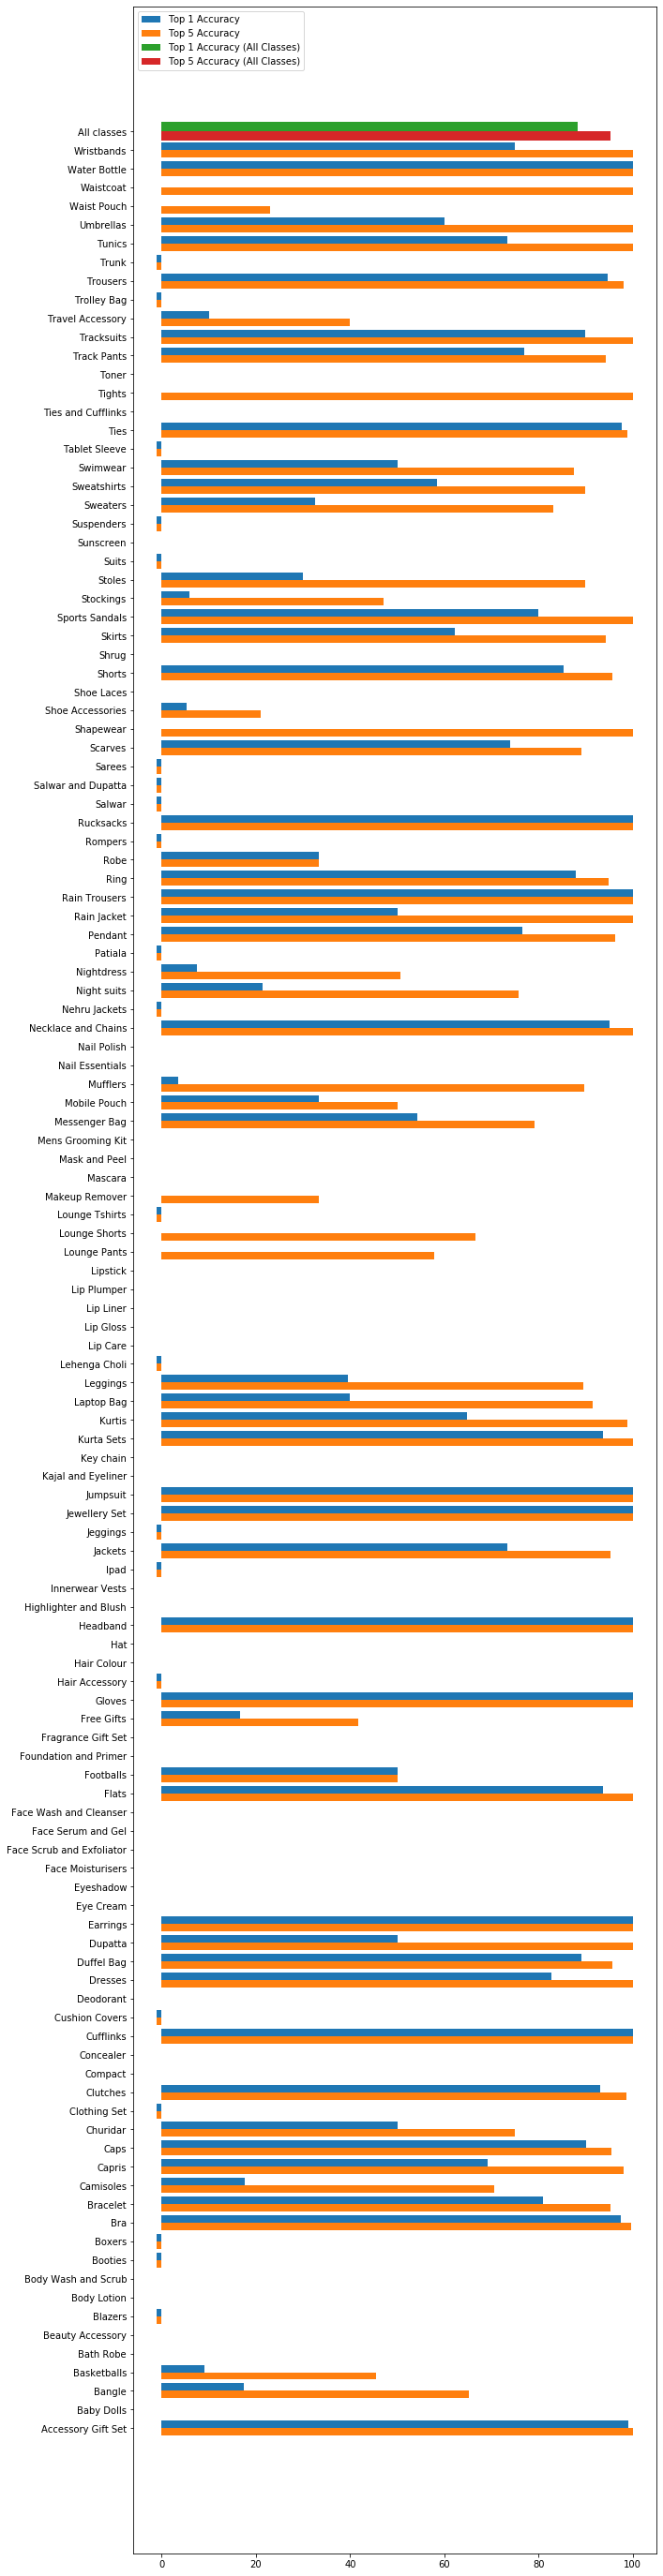

In [53]:
bottom123 = list(datasets['bottom']['test']['data'].classes)

reordered_acc1_classwise = list(acc1_classwise_transfer[datasets['bottom']['test']['data'].target_codec.transform(bottom123)])
reordered_acc5_classwise = list(acc5_classwise_transfer[datasets['bottom']['test']['data'].target_codec.transform(bottom123)])

plt.figure(figsize=(10,50))
plt.barh(bottom123 + ["All classes"], reordered_acc1_classwise + [0.0], label='Top 1 Accuracy', height=0.4, align='edge')
plt.barh(bottom123 + ["All classes"], reordered_acc5_classwise + [0.0], label='Top 5 Accuracy', height=-0.4, align='edge')
plt.barh(bottom123 + ["All classes"], list(np.zeros_like(reordered_acc1_classwise)) + [acc1_avg], label='Top 1 Accuracy (All Classes)', height=0.5, align='edge')
plt.barh(bottom123 + ["All classes"], list(np.zeros_like(reordered_acc5_classwise)) + [acc5_avg], label='Top 5 Accuracy (All Classes)', height=-0.5, align='edge')
plt.legend(loc="upper left")
plt.show()

# 5. Outlook

## 5.1. Todos

The training procedure could probably be improved by the following strategies:

- *hyperparameter optimization*: The most sensitive hyperparameter is the learning rate, which was not optimized in any way for the experiments. Possible optimization strategies are a random search (in logspace) or a Bayesian optimiziation with validation accuracy is the criterion to search over.
- *learning rate schedule*: the annealing of the learning rate was chosen ad-hoc. This could be improved by searching over the annealing hyperparameters together with the learning rate or by implementing a plateau detection to decrease learning rate whenever the validation accuracy plateaus.
- *training/validation split*: currently it is not guaranteed that the training set for the remaining classes in the transfer learning contains samples from all classes, as some might be present in only in the validation set. Stratification was not possible due to the fact that for some classes there is just a single data point.
- *image size*: the choice of 400-by-300 pixels was ad-hoc since it retains the dominant aspect ratio of the original images and is in the ballpark of ImageNet. There could be a better choice for this.

## 5.2. Extensions

The remaining meta-data (fields 'masterCategory' and 'subCategory') could probably be used to improve learning and performance on the test set. The easiest approach would be to encode them as one-hot vectors and concatenate them with the output of the next-to-last layer of the pretrained ImageNet model, then learn a linear layer on top.
For real-world purposes, this would mean that we deem it likely to encounter unseen data where the 'articleType' is not known but at least its 'masterCategory' and 'subCategory' are. There are potential caveats to this approach however, as some of the 'subCategory' labels are dead giveaways to the 'articleType' , e.g. the for 'articleType' 'Watches', the 'subCategory' is always 'Watches'. A model trained on this input might reasonably ignore the visual input entirely and just use the 'subCategory' label, which might not be desired.

Using the field 'productDisplayName' has the same problems. Although I did not analyze this quantitatively, it seems that the 'prductDisplayName' often contains the class label directly or at least slight variations of it. Using this information via NLP techniques bears the risk of overfitting to the text features and ignoring the visual input.